In [2]:
import numpy as np
import cv2
import sys

def _thinningIteration2(im, iter):
    I, M = im, np.zeros_like(im)
    rows=I.shape[1]-2
    cols=I.shape[0]-2
    for i in range(1,rows):
        for j in range(1,cols):
            p2 = int(I[i-1][ j ])
            p3 = int(I[i-1][ j+1 ])
            p4 = int(I[i ][j+1 ])
            p5 = int(I[i+1][ j+1 ])
            p6 = int(I[i+1][ j ])
            p7 = int(I[i+1][ j-1 ])
            p8 = int(I[i ][j-1 ])
            p9 = int(I[i-1][ j-1 ])
            #print(p2)
            C  = (1-p2 & (p3 | p4)) + (1-p4 & (p5 | p6)) +\
                     (1-p6 & (p7 | p8)) + (1-p8 & (p9 | p2))
            N1 = (p9 | p2) + (p3 | p4) + (p5 | p6) + (p7 | p8)
            N2 = (p2 | p3) + (p4 | p5) + (p6 | p7) + (p8 | p9)
            N  = N1 if N1 < N2 else N2
            m  = ((p6 | p7 | 1-p9) & p8) if iter == 0 else ((p2 | p3 | 1-p5) & p4)
            if C == 1 and (N >= 2 and N <= 3) and m == 0:
                M[i][j] = 1.
    
    
    return cv2.bitwise_and(I,1.-M)


def thinning(src):
    dst = src.copy() / 255
    prev = np.zeros(src.shape[:2], np.uint8)
    diff = None

    while True:
        dst = _thinningIteration2(dst, 0)
        dst = _thinningIteration2(dst, 1)
        diff = np.absolute(dst - prev)
        prev = dst.copy()
        if np.sum(diff) == 0:
            break

    return dst * 255



src = cv2.imread('C:\\Users\\egor\\Documents\\marking\\67_1.jpg',0)


_, bw2 = cv2.threshold(src, 10, 255, cv2.THRESH_BINARY)
bw2 = thinning(bw2)
res1 = cv2.resize(src,None,fx=5, fy=5, interpolation = cv2.INTER_LINEAR)
cv2.imshow("src", res1)
res = cv2.resize(bw2,None,fx=5, fy=5, interpolation = cv2.INTER_LINEAR)
cv2.imshow("thinning", res)
cv2.imwrite("C:\\Users\\egor\\Documents\\marking\\tem1p.jpg",bw2)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
from skimage import morphology
import cv2
import numpy as np
im = cv2.imread('C:\\Users\\egor\\Documents\\marking\\67_1.jpg',0)
im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)[1]
im = morphology.skeletonize(im > 0)
print(im)
t=np.array([[1. if el==True else 0 for el in row] for row in im])
cv2.imshow("thinning", t)
cv2.waitKey()
cv2.destroyAllWindows()

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


In [84]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

imgL = cv2.imread('C:\\Users\\egor\\Documents\\Visual Studio 2013\\Projects\\calib\\calib\\l.jpg',0)
imgR = cv2.imread('C:\\Users\\egor\\Documents\\Visual Studio 2013\\Projects\\calib\\calib\\r.jpg',0)
vis = np.concatenate((imgL, imgL), axis=1)
for i in range(50):
    cv2.line(vis,(0,i*16),(2304,i*16),(255,255,255))
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = cv2.normalize(stereo.compute(imgL, imgR),dst=disparity, alpha=0, beta=255, \
    norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
cv2.imshow('gray',vis)
cv2.waitKey()
cv2.destroyAllWindows()

309
310
311
312
313
314
315
316


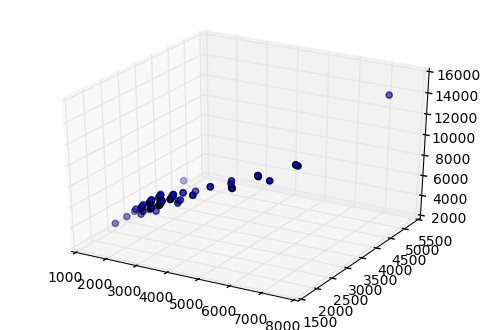

out.ply saved


In [29]:
import yaml
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
end_header
'''

def write_ply(fn, verts):
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f')
def opencv_matrix(loader, node):
    mapping = loader.construct_mapping(node, deep=True)
    mat = np.array(mapping["data"])
    mat.resize(mapping["rows"], mapping["cols"])
    return mat
def getLeftRight_rectificated(imgL,imgR):
    
    yaml.add_constructor(u"tag:yaml.org,2002:opencv-matrix", opencv_matrix)
    
    with open("C:\\Users\\egor\\Documents\\Visual Studio 2013\\Projects\\calib\\calib\\intrinsics.yml", 'r') as fin:
        try:
            result = yaml.load(fin.read())
        except yaml.YAMLError as exc:
            print(exc)
    
    cameraMatrix0=result["M1"]
    cameraMatrix1=result["M2"]
    distCoeffs0=result["D1"]
    distCoeffs1=result["D2"]
    with open("C:\\Users\\egor\\Documents\\Visual Studio 2013\\Projects\\calib\\calib\\extrinsics.yml", 'r') as fin:
        try:
            result = yaml.load(fin.read())
        except yaml.YAMLError as exc:
            print(exc)
    R1=result["R1"]
    R2=result["R2"]
    P1=result["P1"]
    P2=result["P2"]
    T=result["T"]
    imageSizeCropped=result["imageSizeCropped"]
    Q=result["Q"]
    w = imageSizeCropped[0]
    h= imageSizeCropped[1]
    rm00,rm01=cv2.initUndistortRectifyMap(cameraMatrix0, distCoeffs0, R1, P1, tuple(imageSizeCropped), cv2.CV_16SC2)
    rm10,rm11=cv2.initUndistortRectifyMap(cameraMatrix1, distCoeffs1, R2, P2, tuple(imageSizeCropped), cv2.CV_16SC2)
    #imgL=cv2.remap(imgL.copy(),rm00,rm01,cv2.INTER_LINEAR)
    #imgR=cv2.remap(imgR.copy(),rm10,rm11,cv2.INTER_LINEAR)
    retL,threshL = cv2.threshold(imgL,127,255,cv2.THRESH_BINARY)
    retR,threshR = cv2.threshold(imgR,127,255,cv2.THRESH_BINARY)
    return threshL,threshR,Q,T

def getPointsMatches():
    iii=309
    colLeft=[]
    colRight=[]
    correspondedCols=[]
    imgL=cv2.imread('C:\\Users\\egor\\Documents\\github\\diploma\\ball_center\\L\\'+str(iii).zfill(9)+".jpg",cv2.IMREAD_GRAYSCALE)
    imgR=cv2.imread('C:\\Users\\egor\\Documents\\github\\diploma\\ball_center\\R\\'+str(iii).zfill(9)+".jpg",cv2.IMREAD_GRAYSCALE)
    imgL,imgR,Q,T=getLeftRight_rectificated(imgL,imgR)        
    while(1):
        #imgL = cv2.imread('C:\\Users\\egor\\Documents\\github\\diploma\\ball_try\\L_try2\\'+str(iii).zfill(9)+".png",0)
        #imgR = cv2.imread('C:\\Users\\egor\\Documents\\github\\diploma\\ball_try\\R_try2\\'+str(iii).zfill(9)+".png",0)    
        imgL=cv2.imread('C:\\Users\\egor\\Documents\\github\\diploma\\ball_center\\L\\'+str(iii).zfill(9)+".jpg",cv2.IMREAD_GRAYSCALE)
        imgR=cv2.imread('C:\\Users\\egor\\Documents\\github\\diploma\\ball_center\\R\\'+str(iii).zfill(9)+".jpg",cv2.IMREAD_GRAYSCALE)
        print(iii)        
        if(iii>315):
            break
        if(imgL is None):
            iii+=1
            continue
        imgL,imgR,Q,T=getLeftRight_rectificated(imgL,imgR)   
        tempCols=[]
        for rowInd,row in enumerate(imgL):
            flag=False
            for colInd,elLeft in enumerate(row):
                if(elLeft>127):                
                    for ind,elRight in enumerate(imgR[rowInd]):
                        if(elRight>127):
                            correspondedCols.append([colInd,ind,rowInd,np.abs(colInd-ind)])
                            imgL[rowInd][colInd]=0.
                            imgR[rowInd][ind]=0.
                            flag=True
                            break
                elif(flag):
                    break
        iii+=1
        
    return correspondedCols,Q,T   


iii=48
perFrame=True



while(1):
    #imgL = cv2.imread('C:\\Users\\egor\\Documents\\github\\diploma\\ball_try\\L_try2\\'+str(iii).zfill(9)+".png",0)
    #imgR = cv2.imread('C:\\Users\\egor\\Documents\\github\\diploma\\ball_try\\R_try2\\'+str(iii).zfill(9)+".png",0)    
    
    projPoints,Q,T=getPointsMatches()
    Xarr,Yarr,Zarr=[],[],[]
    allArr=[]
    for ind in range(len(projPoints)):        
        x1=projPoints[ind][0]
        x2=projPoints[ind][1]
        y1=projPoints[ind][2]
        b=np.linalg.norm(T)
        f=(1150.416874275448+ 1149.9186412078991)/2
        Z = ( b * f ) / ( np.abs(x1 - x2) )        
        Xarr.append(x1 * Z / f)
        Yarr.append(y1 * Z / f)
        Zarr.append(Z)
        allArr.append([x1 * Z / f,y1 * Z / f,Z])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xarr,Yarr,Zarr)
    plt.show()
    
    
    out_fn = 'out.ply'
    write_ply('out.ply', allArr)
    print('%s saved' % 'out.ply')
    k = cv2.waitKey(0)
    break
    delay = 1
    iii+=1
    
    if k == 27:
        break   
    if k == 32 or perFrame==True:
        k = cv2.waitKey(0)
        if(k==32):
            perFrame=False
            continue        
        if(k == 2555904): 
            perFrame=True
            continue
cv2.destroyAllWindows()

In [11]:
import cv2
t=[1,1,1]
t

[1, 1, 1]